# Multiclass Peak Detection in fDOM

This file combines all of the fDOM detection scripts into a singular classifier, that detects all peak types. On top of this, it also leverages the augmented data created previously.

## Structure

The core structure of the project is to have all individual classifiers running, and then when one detects a peak, it alerts the overall classifier "manager", which then takes note of the peak that a classifier has detected as an anomaly peak.


In [1]:
# Imports
from sklearn.model_selection import TimeSeriesSplit, KFold, StratifiedKFold
import seaborn as sn
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
)
import pandas as pd
import numpy as np
import datetime
import copy
import matplotlib.pyplot as plt
import pickle
import progressbar

import Tools.data_processing as dp
import Tools.data_movement as dm
from Tools.get_all_cands import get_all_cands_fDOM, get_all_truths_fDOM

# import classifiers
from Anomaly_Detection.Multiclass_Detection.fdom_classifiers.fDOM_PLP import (
    fDOM_PLP_Classifier,
)
from Anomaly_Detection.Multiclass_Detection.fdom_classifiers.fDOM_FPT import (
    fDOM_FPT_Classifier,
)
from Anomaly_Detection.Multiclass_Detection.fdom_classifiers.fDOM_FSK import (
    fDOM_FSK_Classifier,
)
from Anomaly_Detection.Multiclass_Detection.fdom_classifiers.fDOM_PP import (
    fDOM_PP_Classifier,
)
from Anomaly_Detection.Multiclass_Detection.fdom_classifiers.fDOM_SKP import (
    fDOM_SKP_Classifier,
)

# disable warnings
def warn(*args, **kwargs):
    pass


import warnings

warnings.warn = warn


## Training parameters and helper functions


In [2]:
ITERATIONS = 100
NUM_SPLITS = 5
AUGMENT_DATA_BEGIN_TIMESTAMP = 2459096.9583333335
USE_AUGMENTED_DATA = True
CLASS_BALANCED_ONLY = False

# for confusion matrix
DATA_LABELS = ["PLP", "SKP", "PP", "FPT", "FSK", "NAP"]

# Useful functions
def get_prediction(plp_pred, skp_pred, pp_pred, fpt_pred, fsk_pred):
    """
    take the top level prediction based on peak precendence
    """

    if plp_pred == "PLP":
        return plp_pred

    elif pp_pred == "PP":
        return pp_pred

    elif skp_pred == "SKP":
        return skp_pred

    elif fsk_pred == "FSK":
        return fsk_pred

    elif fpt_pred == "FPT":
        return fpt_pred

    else:
        return "NAP"


In [3]:
# Filenames
fdom_raw_data = "Data/converted_data/julian_format/fDOM_raw_10.1.2011-9.4.2020.csv"
stage_raw_data = "Data/converted_data/julian_format/stage_10.1.11-1.1.19.csv"
turb_raw_data = "Data/converted_data/julian_format/turbidity_raw_10.1.2011_9.4.2020.csv"

fdom_labeled = "Data/labeled_data/ground_truths/fDOM/fDOM_all_julian_0k-300k.csv"

fdom_raw_augmented = "Data/augmented_data/fdom/unlabeled/unlabeled_fdom.csv"
fdom_labeled_augmented = "Data/augmented_data/fdom/labeled/labeled_fdom_peaks.csv"

turb_augmented_raw_data = "Data/augmented_data/fdom/unlabeled/unlabeled_turb.csv"

stage_augmented_data_fn = "Data/augmented_data/fdom/unlabeled/unlabeled_stage.csv"

# to get fsk/fpt peaks in augmented data
fdom_fpt_lookup_path = "Data/augmented_data/fdom/fpt_lookup.csv"
fdom_fsk_lookup_path = "Data/augmented_data/fdom/fsk_lookup.csv"


In [4]:
# Load Data
fDOM_data = dm.read_in_preprocessed_timeseries(fdom_raw_data)
stage_data = dm.read_in_preprocessed_timeseries(stage_raw_data)
turb_data = dm.read_in_preprocessed_timeseries(turb_raw_data)
stage_data = dp.align_stage_to_fDOM(fDOM_data, stage_data)

augmented_fdom_data = np.array(dm.read_in_timeseries(fdom_raw_augmented, True))
augmented_turb_data = np.array(dm.read_in_timeseries(turb_augmented_raw_data, True))
augmented_stage_data = np.array(dm.read_in_timeseries(stage_augmented_data_fn, True))


## Get Candidates and truths


In [5]:
# get candidates from raw data
cands = get_all_cands_fDOM(
    fdom_raw_data,
    fdom_labeled,
)

# get truths from raw data
truths = get_all_truths_fDOM(fdom_labeled)

# assert they are the same size
assert truths.shape == cands.shape

print(f"Total number of original data candidates: {cands.shape[0]}")


Total number of original data candidates: 1636


### Augmented Data

Make sure that `USE_AUGMENTED_DATA` == `True`, for this data to take effect


In [6]:
if USE_AUGMENTED_DATA:
    # get candidates from augmented data
    cands_augmented = get_all_cands_fDOM(
        fdom_raw_augmented,
        fdom_labeled_augmented,
        True,
        fdom_fpt_lookup_path,
        fdom_fsk_lookup_path,
    )

    truths_augmented = get_all_truths_fDOM(fdom_labeled_augmented, True)

    # align the missing augmented data (FPT, NFPT, FSK, NFSK, some others)
    truths_augmented = truths_augmented[
        truths_augmented["idx_of_peak"].isin(cands_augmented["idx_of_peak"])
    ]

    assert truths_augmented.shape == cands_augmented.shape

    print(f"Total number of augmented candidates: {cands_augmented.shape[0]}")

    # concatenate two candidates and truths into single list
    cands = pd.concat([cands, cands_augmented])
    truths = pd.concat([truths, truths_augmented])

    # concat augmented raw data to normal raw data, for classifier preprocessing
    turb_data_total = np.concatenate((turb_data, augmented_turb_data))
    fdom_total = np.concatenate((fDOM_data, augmented_fdom_data))
    stage_total = np.concatenate((stage_data, augmented_stage_data))

# if we aren't using augmented data, make sure classifiers have correct data being passed into them for preprocessing
else:
    turb_data_total = turb_data
    fdom_total = fDOM_data
    stage_total = stage_data


Total number of augmented candidates: 3764


## Alternatively, use only augmented data for pure class balanced training/testing


In [7]:
if CLASS_BALANCED_ONLY:
    # get candidates from augmented data
    cands = get_all_cands_fDOM(
        fdom_raw_augmented,
        fdom_labeled_augmented,
        True,
        fdom_fpt_lookup_path,
        fdom_fsk_lookup_path,
    )

    truths = get_all_truths_fDOM(fdom_labeled_augmented, True)

    # align the missing augmented data (FPT, NFPT, FSK, NFSK, some others)
    truths = truths[truths["idx_of_peak"].isin(cands["idx_of_peak"])]

    assert truths.shape == cands.shape

    print(f"Total number of candidates: {cands.shape[0]}")

    turb_data_total = augmented_turb_data
    fdom_total = augmented_fdom_data
    stage_total = augmented_stage_data


In [8]:
# Convert cands and truths into lists
cands = cands.values.tolist()

truths = truths.values.tolist()

print(str(len(cands)) + " candidates in provided data.")


5400 candidates in provided data.


In [9]:
train_cands = cands_augmented.values.tolist()
train_truths = truths_augmented.values.tolist()


## Create Classifiers


In [10]:
plp_classifer = fDOM_PLP_Classifier(
    fdom_total,
    turb_data_total,
    fdom_raw_data,
    fdom_labeled,
    fdom_raw_augmented,
    fdom_labeled_augmented,
)


In [11]:
skp_classifier = fDOM_SKP_Classifier(
    fdom_total, fdom_raw_data, fdom_labeled, fdom_raw_augmented, fdom_labeled_augmented
)


In [12]:
pp_classifier = fDOM_PP_Classifier(
    fdom_total, stage_total, AUGMENT_DATA_BEGIN_TIMESTAMP
)


In [13]:
fpt_classifier = fDOM_FPT_Classifier(fdom_total)


In [14]:
fsk_classifier = fDOM_FSK_Classifier(fdom_total)


## Training Loop


In [15]:
accumulated_test_metrics = {}

accumulated_test_results = {}

accumulated_best_params = {}

accumulated_cfmxs = {}

discovered_labels = []

# split data
tss = TimeSeriesSplit(NUM_SPLITS)
kf = KFold(NUM_SPLITS)
skf = StratifiedKFold(NUM_SPLITS)

overall_start = datetime.datetime.now()

split = 1
divide_by_zero_errs = 0

for train_val_indices, test_indices in kf.split(cands):
    X_train, y_train = [cands[i] for i in train_val_indices], [
        truths[i] for i in train_val_indices
    ]

    X_test, y_test = [cands[i] for i in test_indices], [truths[i] for i in test_indices]

    max_fold_metric = 0
    max_result = None

    # print out info for user
    print("\nSplit: ", split)
    split_start = datetime.datetime.now()
    num_pos_test = len(list(filter(lambda x: x[2] != "NAP", y_test)))
    num_pos_train = len(list(filter(lambda x: x[2] != "NAP", y_train)))

    print(f"Num Pos in Test: {num_pos_test}")
    print(f"Num Pos in Train: {num_pos_train}")

    if num_pos_test >= 1 and num_pos_train >= 1:
        # instantiate the progress bar
        pbar = progressbar.ProgressBar(max_value=ITERATIONS)

        # main training loop
        for iteration in range(ITERATIONS):
            params = {}

            # start the iteration for each classifier (resets predictions, generates params)
            params["plp"] = plp_classifer.start_iteration()
            params["skp"] = skp_classifier.start_iteration()
            params["pp"] = pp_classifier.start_iteration()
            params["fpt"] = fpt_classifier.start_iteration()
            params["fsk"] = fsk_classifier.start_iteration()

            # empty predictions array
            train_preds = []

            plp_preds = plp_classifer.classify_samples(X_train)
            skp_preds = skp_classifier.classify_samples(X_train)
            pp_preds = pp_classifier.classify_samples(X_train)
            fpt_preds = fpt_classifier.classify_samples(X_train)
            fsk_preds = fsk_classifier.classify_samples(X_train)
            for i, pred in enumerate(plp_preds):
                train_pred = get_prediction(
                    pred[1], skp_preds[i][1], pp_preds[i][1], fpt_preds[i][1], fsk_preds[i][1]
                )
                train_preds.append(train_pred)

            ######## GET SCORES ########
            bal_acc = balanced_accuracy_score(
                [row[2] for row in y_train],
                [row for row in train_preds],
            )

            acc = accuracy_score(
                [row[2] for row in y_train],
                [row for row in train_preds],
            )

            f1_train = f1_score(
                [row[2] for row in y_train], [row for row in train_preds], average=None
            )

            # print out acc in 10 even splits
            if iteration and iteration % int(ITERATIONS / 10) == 0:
                print("Iteration {} acc: {} ".format(iteration, acc), end="")

            # check acc, if better than max fold, save it
            if acc > max_fold_metric:
                max_fold_metric = acc
                max_result = copy.deepcopy(train_preds)

                # save params of classifiers
                plp_classifer.got_best_result()
                skp_classifier.got_best_result()
                pp_classifier.got_best_results()
                fpt_classifier.got_best_results()
                fsk_classifier.got_best_results()

            # call end of iteration, as we are at the end of an iteration
            # allows individual classifiers to calc results
            plp_classifer.end_of_iteration(y_train)
            skp_classifier.end_of_iteration(y_train)
            pp_classifier.end_of_iteration(y_train)
            fpt_classifier.end_of_iteration(y_train)
            fsk_classifier.end_of_iteration(y_train)

            # update the progressbar
            pbar.update(iteration)

        # perform peak testing
        test_preds = []
        plp_preds = plp_classifer.classify_samples(X_test, True)
        skp_preds = skp_classifier.classify_samples(X_test, True)
        pp_preds = pp_classifier.classify_samples(X_test, True)
        fpt_preds = fpt_classifier.classify_samples(X_test, True)
        fsk_preds = fsk_classifier.classify_samples(X_test, True)

        for i, pred in enumerate(plp_preds):
            test_pred = get_prediction(
                pred[1], skp_preds[i][1], pp_preds[i][1], fpt_preds[i][1], fsk_preds[i][1]
            )
            test_preds.append(test_pred)

        ######## GET SCORES ########
        # get confusion matrix
        cfmx = confusion_matrix(
            [row[2] for row in y_test],
            [row for row in test_preds],
            labels=DATA_LABELS,
        )

        # get acc score
        acc_score = accuracy_score(
            [row[2] for row in y_test],
            [row for row in test_preds],
        )

        bal_acc = balanced_accuracy_score(
            [row[2] for row in y_test],
            [row for row in test_preds],
        )

        f1 = f1_score(
            [row[2] for row in y_test],
            [row for row in test_preds],
            average="weighted",
        )

        precision = precision_score(
            [row[2] for row in y_test],
            [row for row in test_preds],
            average="weighted",
        )

        print(f"\nSplit {split} test Scores: F1: {f1}  BA: {bal_acc}  ACC: {acc_score}")

        accumulated_cfmxs[split] = copy.deepcopy(cfmx)

        accumulated_test_metrics[split] = {
            "f1": f1,
            "acc": acc_score,
            "ba": bal_acc,
            "precision": precision,
        }

        accumulated_test_results[split] = copy.deepcopy(test_preds)

        # save the best params
        accumulated_best_params[split] = {
            "PLP": copy.deepcopy(plp_classifer.best_params),
            "SKP": copy.deepcopy(skp_classifier.best_params),
            "PP": copy.deepcopy(pp_classifier.best_params),
            "FPT": copy.deepcopy(fpt_classifier.best_params),
            "FSK": copy.deepcopy(fsk_classifier.best_params)
        }

        # increment split
        split += 1

# print a newline char for better display
print("\n")

overall_end_time = datetime.datetime.now()


  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Split:  1
Num Pos in Test: 62
Num Pos in Train: 3310


 11% (11 of 100) |##                     | Elapsed Time: 0:00:02 ETA:   0:00:17

Iteration 10 acc: 0.25625 

 21% (21 of 100) |####                   | Elapsed Time: 0:00:04 ETA:   0:00:15

Iteration 20 acc: 0.13125 

 30% (30 of 100) |######                 | Elapsed Time: 0:00:05 ETA:   0:00:13

Iteration 30 acc: 0.23981481481481481 

 41% (41 of 100) |#########              | Elapsed Time: 0:00:07 ETA:   0:00:11

Iteration 40 acc: 0.2537037037037037 

 51% (51 of 100) |###########            | Elapsed Time: 0:00:09 ETA:   0:00:09

Iteration 50 acc: 0.24675925925925926 

 61% (61 of 100) |##############         | Elapsed Time: 0:00:11 ETA:   0:00:07

Iteration 60 acc: 0.2953703703703704 

 70% (70 of 100) |################       | Elapsed Time: 0:00:13 ETA:   0:00:05

Iteration 70 acc: 0.27291666666666664 

 81% (81 of 100) |##################     | Elapsed Time: 0:00:15 ETA:   0:00:03

Iteration 80 acc: 0.2659722222222222 

 91% (91 of 100) |####################   | Elapsed Time: 0:00:17 ETA:   0:00:01

Iteration 90 acc: 0.2520833333333333 

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Split 1 test Scores: F1: 0.9077883212519265  BA: 0.24451655907942746  ACC: 0.9120370370370371

Split:  2
Num Pos in Test: 502
Num Pos in Train: 2870


 11% (11 of 100) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:14

Iteration 10 acc: 0.37083333333333335 

 21% (21 of 100) |####                   | Elapsed Time: 0:00:03 ETA:   0:00:13

Iteration 20 acc: 0.20833333333333334 

 31% (31 of 100) |#######                | Elapsed Time: 0:00:05 ETA:   0:00:11

Iteration 30 acc: 0.3261574074074074 

 41% (41 of 100) |#########              | Elapsed Time: 0:00:06 ETA:   0:00:09

Iteration 40 acc: 0.3645833333333333 

 50% (50 of 100) |###########            | Elapsed Time: 0:00:08 ETA:   0:00:08

Iteration 50 acc: 0.34953703703703703 

 61% (61 of 100) |##############         | Elapsed Time: 0:00:10 ETA:   0:00:06

Iteration 60 acc: 0.3625 

 71% (71 of 100) |################       | Elapsed Time: 0:00:12 ETA:   0:00:04

Iteration 70 acc: 0.3509259259259259 

 81% (81 of 100) |##################     | Elapsed Time: 0:00:13 ETA:   0:00:02

Iteration 80 acc: 0.38564814814814813 

 90% (90 of 100) |####################   | Elapsed Time: 0:00:15 ETA:   0:00:01

Iteration 90 acc: 0.3351851851851852 

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Split 2 test Scores: F1: 0.40012728573517564  BA: 0.19029281541838747  ACC: 0.5407407407407407

Split:  3
Num Pos in Test: 943
Num Pos in Train: 2429


 11% (11 of 100) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:13

Iteration 10 acc: 0.46087962962962964 

 21% (21 of 100) |####                   | Elapsed Time: 0:00:03 ETA:   0:00:12

Iteration 20 acc: 0.46064814814814814 

 31% (31 of 100) |#######                | Elapsed Time: 0:00:04 ETA:   0:00:10

Iteration 30 acc: 0.4909722222222222 

 41% (41 of 100) |#########              | Elapsed Time: 0:00:06 ETA:   0:00:09

Iteration 40 acc: 0.4638888888888889 

 51% (51 of 100) |###########            | Elapsed Time: 0:00:08 ETA:   0:00:08

Iteration 50 acc: 0.4550925925925926 

 60% (60 of 100) |#############          | Elapsed Time: 0:00:09 ETA:   0:00:06

Iteration 60 acc: 0.44675925925925924 

 71% (71 of 100) |################       | Elapsed Time: 0:00:11 ETA:   0:00:05

Iteration 70 acc: 0.44699074074074074 

 81% (81 of 100) |##################     | Elapsed Time: 0:00:13 ETA:   0:00:03

Iteration 80 acc: 0.48865740740740743 

 91% (91 of 100) |####################   | Elapsed Time: 0:00:14 ETA:   0:00:01

Iteration 90 acc: 0.456712962962963 

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Split 3 test Scores: F1: 0.05573847183042585  BA: 0.1748218823923665  ACC: 0.13518518518518519

Split:  4
Num Pos in Test: 928
Num Pos in Train: 2444


 11% (11 of 100) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:14

Iteration 10 acc: 0.4706018518518518 

 21% (21 of 100) |####                   | Elapsed Time: 0:00:03 ETA:   0:00:13

Iteration 20 acc: 0.4513888888888889 

 31% (31 of 100) |#######                | Elapsed Time: 0:00:05 ETA:   0:00:11

Iteration 30 acc: 0.47662037037037036 

 40% (40 of 100) |#########              | Elapsed Time: 0:00:06 ETA:   0:00:10

Iteration 40 acc: 0.4597222222222222 

 51% (51 of 100) |###########            | Elapsed Time: 0:00:08 ETA:   0:00:08

Iteration 50 acc: 0.4625 

 61% (61 of 100) |##############         | Elapsed Time: 0:00:10 ETA:   0:00:06

Iteration 60 acc: 0.3733796296296296 

 71% (71 of 100) |################       | Elapsed Time: 0:00:11 ETA:   0:00:04

Iteration 70 acc: 0.493287037037037 

 80% (80 of 100) |##################     | Elapsed Time: 0:00:13 ETA:   0:00:03

Iteration 80 acc: 0.4861111111111111 

 91% (91 of 100) |####################   | Elapsed Time: 0:00:15 ETA:   0:00:01

Iteration 90 acc: 0.46805555555555556 

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Split 4 test Scores: F1: 0.06749159331364017  BA: 0.18001037766278205  ACC: 0.1527777777777778

Split:  5
Num Pos in Test: 937
Num Pos in Train: 2435


 11% (11 of 100) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:14

Iteration 10 acc: 0.29791666666666666 

 20% (20 of 100) |####                   | Elapsed Time: 0:00:03 ETA:   0:00:13

Iteration 20 acc: 0.48032407407407407 

 31% (31 of 100) |#######                | Elapsed Time: 0:00:05 ETA:   0:00:11

Iteration 30 acc: 0.4935185185185185 

 41% (41 of 100) |#########              | Elapsed Time: 0:00:06 ETA:   0:00:10

Iteration 40 acc: 0.44907407407407407 

 51% (51 of 100) |###########            | Elapsed Time: 0:00:08 ETA:   0:00:08

Iteration 50 acc: 0.45578703703703705 

 60% (60 of 100) |#############          | Elapsed Time: 0:00:10 ETA:   0:00:06

Iteration 60 acc: 0.43171296296296297 

 71% (71 of 100) |################       | Elapsed Time: 0:00:12 ETA:   0:00:05

Iteration 70 acc: 0.456712962962963 

 81% (81 of 100) |##################     | Elapsed Time: 0:00:13 ETA:   0:00:03

Iteration 80 acc: 0.381712962962963 

 91% (91 of 100) |####################   | Elapsed Time: 0:00:15 ETA:   0:00:01

Iteration 90 acc: 0.44675925925925924 

 99% (99 of 100) |###################### | Elapsed Time: 0:00:16 ETA:   0:00:00


Split 5 test Scores: F1: 0.06262008625740281  BA: 0.18208498328980258  ACC: 0.14722222222222223




## Display Metrics


Mean Test F1:  0.29875315167771427
Mean Test BA:  0.19434532356855322
Mean Test Acc:  0.3775925925925926
Mean Test Precision:  0.33624327749218674

Params from split 1:

For peak type PLP:
max_basewidth, value: 4
min_prominence, value: 9.331089105203517
interference_x_proximity, value: 5
interference_y_proximity, value: 1
proximity_threshold, value: 17

For peak type SKP:
max_basewidth, value: 7
min_prominence, value: 14.73309042610156
downward_bases_threshold, value: 2
proximity_threshold, value: 0

For peak type PP:
x, value: 69
y, value: 83
ratio_threshold, value: 16.81573877006575

For peak type FPT:
basewidth, value: 6
prominence, value: 50
prom_diff, value: 1.548029175945301

For peak type FSK:
basewidth, value: 1
prominence, value: 201
prom_diff, value: 1.8994480581316078

Params from split 2:

For peak type PLP:
max_basewidth, value: 4
min_prominence, value: 6.260612460424312
interference_x_proximity, value: 6
interference_y_proximity, value: 1
proximity_threshold, value: 15

F

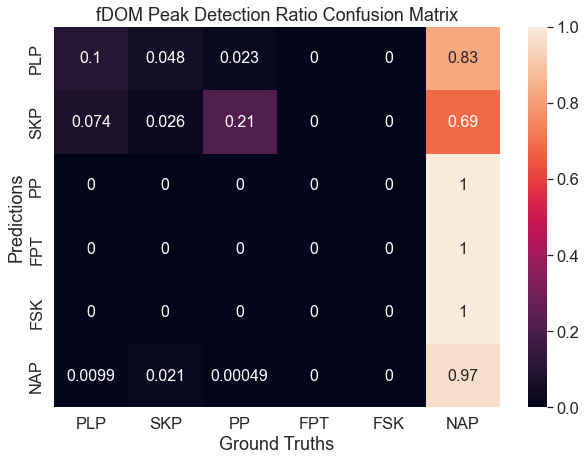

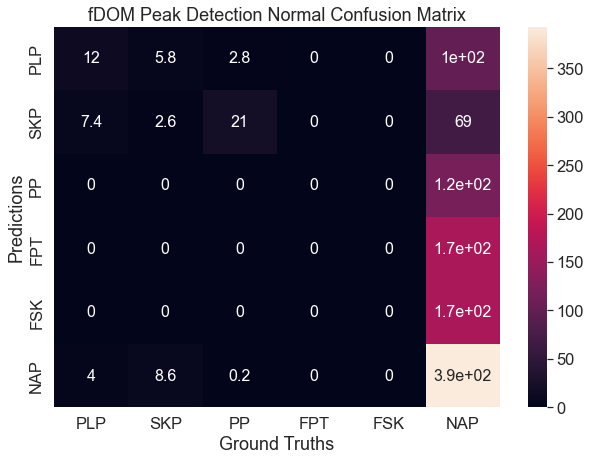

In [19]:
mean_f1 = 0
mean_ba = 0
mean_precision = 0
mean_acc = 0

for key in accumulated_test_metrics:
    metrics = accumulated_test_metrics[key]

    mean_f1 += metrics["f1"]
    mean_ba += metrics["ba"]
    mean_precision += metrics["precision"]
    mean_acc += metrics["acc"]

print("Mean Test F1: ", mean_f1 / len(accumulated_test_metrics))
print("Mean Test BA: ", mean_ba / len(accumulated_test_metrics))
print("Mean Test Acc: ", mean_acc / len(accumulated_test_metrics))
print("Mean Test Precision: ", mean_precision / len(accumulated_test_metrics))

for split in accumulated_best_params.keys():
    print(f"\nParams from split {split}:")
    for peak in accumulated_best_params[split].keys():
        print(f"\nFor peak type {peak}:")

        for param in accumulated_best_params[split][peak].keys():
            print(f"{param}, value: {accumulated_best_params[split][peak][param]}")

# print("Training time: ", overall_end_time - overall_start)

mean_cfmx = np.zeros((len(DATA_LABELS), len(DATA_LABELS)))
for key in accumulated_cfmxs.keys():
    mean_cfmx += accumulated_cfmxs[key]

mean_cfmx = mean_cfmx / len(accumulated_cfmxs)

plt.figure(figsize=(10, 7))
plt.title(label="fDOM Peak Detection Ratio Confusion Matrix")

sn.set(font_scale=1.5)

sn.heatmap(
    pd.DataFrame(
        mean_cfmx.astype("float") / mean_cfmx.sum(axis=1)[:, np.newaxis],
        index=DATA_LABELS,
        columns=DATA_LABELS,
    ),
    annot=True,
    annot_kws={"size": 16},
)

plt.xlabel("Ground Truths")
plt.ylabel("Predictions")
plt.show()

plt.figure(figsize=(10, 7))
plt.title(label="fDOM Peak Detection Normal Confusion Matrix")

sn.set(font_scale=1.5)

sn.heatmap(
    pd.DataFrame(
        mean_cfmx,
        index=DATA_LABELS,
        columns=DATA_LABELS,
    ),
    annot=True,
    annot_kws={"size": 16},
)

plt.xlabel("Ground Truths")
plt.ylabel("Predictions")
plt.show()


In [17]:
with open(
    "Anomaly_Detection/Multiclass_Detection/Experimental_Results/fdom_multiclass/best_params.pkl",
    "wb",
) as pck_file:
    pickle.dump(accumulated_best_params, pck_file)
    pck_file.close()

# Pickle test results
with open(
    "Anomaly_Detection/Multiclass_Detection/Experimental_Results/fdom_multiclass/test_results.pkl",
    "wb",
) as pck_file:
    pickle.dump(accumulated_test_results, pck_file)
    pck_file.close()

# Pickle test metrics
with open(
    "Anomaly_Detection/Multiclass_Detection/Experimental_Results/fdom_multiclass/test_metrics.pkl",
    "wb",
) as pck_file:
    pickle.dump(accumulated_test_metrics, pck_file)
    pck_file.close()


### Statistics from individual classifiers


In [18]:
# print accuracies
print("PLP CLASSIFIER INFO:")
print("ACC: " + str(plp_classifer.best_acc))
print("f1: " + str(plp_classifer.best_f1_score))
print("\n")

print("SKP CLASSIFIER INFO:")
print("ACC: " + str(skp_classifier.best_acc))
print("f1: " + str(skp_classifier.best_f1_score))
print("\n")

print("PP CLASSIFIER INFO:")
print("ACC: " + str(pp_classifier.best_acc))
print("f1: " + str(pp_classifier.best_f1_score))
print("\n")


PLP CLASSIFIER INFO:
ACC: 0.600228759415901
f1: 0.39111111111111113


SKP CLASSIFIER INFO:
ACC: 0.5934264347845032
f1: 0.3862714508580343


PP CLASSIFIER INFO:
ACC: 0.5670052669132185
f1: 0.555536421560186


